# classification-12

## What's new:

1- Improve labeling ( 3333 from 28-1111 )

## next step:

1-


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape, TimeDistributed, Lambda, RepeatVector, Dropout, BatchNormalization
from tensorflow.keras import Input, layers, models, callbacks, metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter, find_peaks, peak_prominences



In [ ]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [ ]:
df.shape

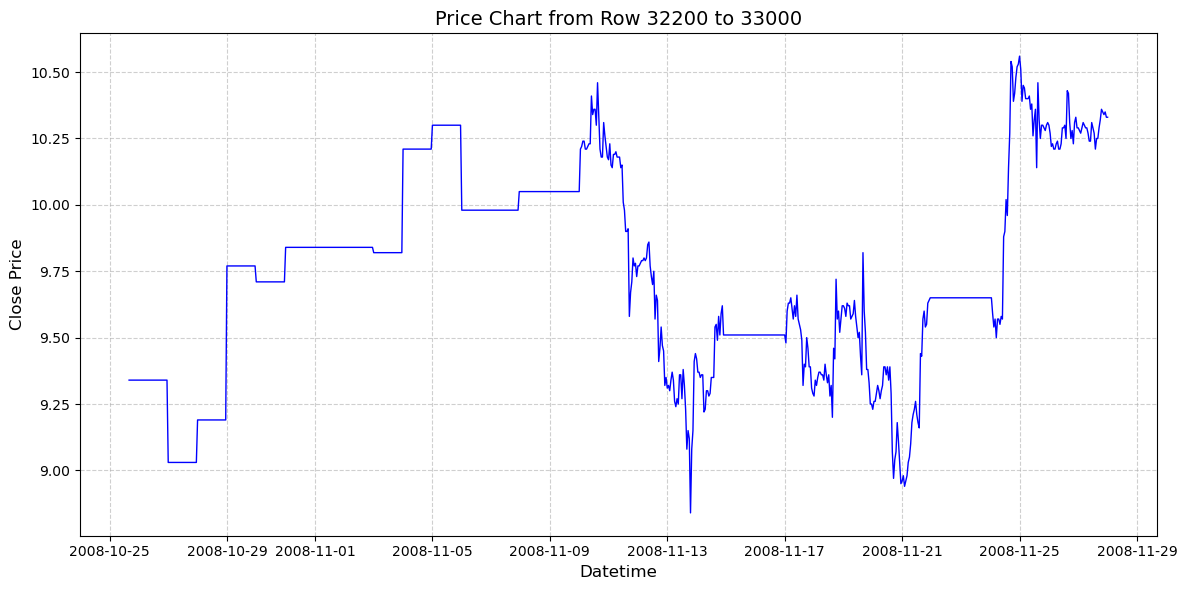

In [6]:
# Example: choose the start and end rows
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [7]:
# Specify how many rows to remove for model
nn = 33000  # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500  # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df) - mm].reset_index(drop=True)

In [8]:
def label_reversal_points(
        close,
        high=None,
        low=None,
        smoothing_window=31,
        polyorder=3,
        base_prom_factor=0.02,
        distance=3,
        snap_window=5,
        min_dev_pct=0.0015,  # 0.15% minimum leg size
        min_dev_sigma=2.0,  # >= 2x local abs-return EMA
        vol_window=100,  # EMA window for local volatility
        verbose=False
):
    """
    Label reversal points with improved accuracy.

    Returns labels array of length n where:
    0 = none, 1 = valley, 2 = peak.

    Tips:
    - For best accuracy, pass high/low arrays from your OHLCV.
      Example: label_reversal_points(df['CLOSE'], df['HIGH'], df['LOW'])
    - Tune min_dev_pct / min_dev_sigma to be stricter or looser on swing size.
    """
    close = np.asarray(close, dtype=float)
    n = close.size
    if n < 3:
        return np.zeros(n, dtype=int)

    # Interpolate NaNs if any
    if np.isnan(close).any():
        idx = np.arange(n)
        good = ~np.isnan(close)
        close = close.copy()
        close[~good] = np.interp(idx[~good], idx[good], close[good])

    # Helper: simple EMA for local abs-return volatility
    def ema(x, span):
        x = np.asarray(x, dtype=float)
        alpha = 2.0 / (span + 1.0)
        out = np.empty_like(x)
        out[0] = x[0]
        for i in range(1, len(x)):
            out[i] = alpha * x[i] + (1 - alpha) * out[i - 1]
        return out

    # Local volatility in price terms via EMA of absolute returns
    ret = np.zeros(n)
    ret[1:] = np.abs(np.diff(close) / np.maximum(1e-12, close[:-1]))
    vol_absret = ema(ret, vol_window)
    local_vol_price = vol_absret * close  # convert to price units

    # Smoothing to get robust candidates
    win = smoothing_window
    if win >= n:
        win = n - 1 if (n - 1) % 2 == 1 else n - 2
    if win % 2 == 0:
        win += 1
    smoothed = savgol_filter(close, win, polyorder)

    # Base prominence threshold
    global_std = np.std(close) or 1.0
    prom = global_std * base_prom_factor

    # Candidate peaks/valleys on smoothed
    peak_idx, _ = find_peaks(smoothed, distance=distance, prominence=prom)
    val_idx, _ = find_peaks(-smoothed, distance=distance, prominence=prom)

    # Prominences for tie-breaking
    peak_prom = peak_prominences(smoothed, peak_idx)[0] if peak_idx.size else np.array([])
    val_prom = peak_prominences(-smoothed, val_idx)[0] if val_idx.size else np.array([])

    # Combine
    candidates = []
    for i, p in enumerate(peak_idx):
        candidates.append((int(p), 2, float(peak_prom[i]) if peak_prom.size else 0.0))
    for i, v in enumerate(val_idx):
        candidates.append((int(v), 1, float(val_prom[i]) if val_prom.size else 0.0))
    candidates.sort(key=lambda x: x[0])

    if not candidates:
        labels = np.zeros(n, dtype=int)
        # still mark edges for completeness
        labels[0] = 1 if close[1] > close[0] else 2
        labels[-1] = 1 if close[-1] > close[-2] else 2
        return labels

    # Enforce alternation (remove weaker when two same-type neighbors)
    def enforce_alternation(ext):
        ext = ext[:]  # list of (idx, typ, prom)
        while True:
            removed = False
            i = 0
            while i < len(ext) - 1:
                if ext[i][1] == ext[i + 1][1]:
                    # drop the smaller prominence
                    if ext[i][2] < ext[i + 1][2]:
                        ext.pop(i)
                    else:
                        ext.pop(i + 1)
                    removed = True
                else:
                    i += 1
            if not removed:
                break
        return ext

    candidates = enforce_alternation(candidates)

    # SNAP: move each extreme to the true local extremum on raw close (or HIGH/LOW)
    def snap_index(idx, typ):
        L = max(0, idx - snap_window)
        R = min(n, idx + snap_window + 1)
        if high is not None and low is not None:
            if typ == 2:  # peak
                j = np.argmax(np.asarray(high[L:R], dtype=float))
            else:  # valley
                j = np.argmin(np.asarray(low[L:R], dtype=float))
        else:
            if typ == 2:
                j = np.argmax(close[L:R])
            else:
                j = np.argmin(close[L:R])
        return L + int(j)

    snapped = []
    seen_at = {}  # avoid duplicate indices by keeping stronger prominence
    for idx, typ, pr in candidates:
        j = snap_index(idx, typ)
        key = (j, typ)
        if key not in seen_at or pr > seen_at[key][2]:
            seen_at[key] = (j, typ, pr)
    snapped = sorted(seen_at.values(), key=lambda x: x[0])

    # Enforce alternation again after snapping
    snapped = enforce_alternation(snapped)

    # Filter micro-legs using adaptive threshold (min % move and sigma*local_vol)
    pruned = []
    for idx, typ, pr in snapped:
        if not pruned:
            pruned.append((idx, typ, pr))
            continue
        prev_idx, prev_typ, prev_pr = pruned[-1]
        # time spacing
        if idx - prev_idx < distance:
            # keep the more prominent of the two
            if pr > prev_pr:
                pruned[-1] = (idx, typ, pr)
            continue
        leg = abs(close[idx] - close[prev_idx])
        # thresholds at both ends
        thr = max(min_dev_pct * close[prev_idx],
                  min_dev_sigma * max(local_vol_price[prev_idx], 1e-12))
        thr = max(thr, max(min_dev_pct * close[idx],
                           min_dev_sigma * max(local_vol_price[idx], 1e-12)))
        if leg >= thr:
            pruned.append((idx, typ, pr))
        else:
            # too small swing → drop the later point
            continue

    # One more alternation pass (paranoid) and spacing check
    pruned = enforce_alternation(pruned)
    final_ext = []
    for idx, typ, pr in pruned:
        if final_ext and idx - final_ext[-1][0] < distance:
            # keep stronger
            if pr > final_ext[-1][2]:
                final_ext[-1] = (idx, typ, pr)
        else:
            final_ext.append((idx, typ, pr))

    # Build labels
    labels = np.zeros(n, dtype=int)
    for idx, typ, _ in final_ext:
        labels[idx] = typ

    # Mark edges as trend boundaries for continuity
    if labels[0] == 0:
        labels[0] = 1 if close[min(1, n - 1)] > close[0] else 2
    if labels[-1] == 0 and n >= 2:
        labels[-1] = 1 if close[-1] > close[-2] else 2

    if verbose:
        c0 = int((labels == 0).sum())
        c1 = int((labels == 1).sum())
        c2 = int((labels == 2).sum())
        print(f"labels -> 0:{c0}  1:{c1}  2:{c2}  (extrema kept: {len(final_ext)})")

    return labels


In [9]:
# baseline (close-only)
df_model['Label'] = label_reversal_points(df_model['CLOSE'].values, verbose=True)

# inspect counts
print(df_model['Label'].value_counts())

labels -> 0:144229  1:1063  2:1064  (extrema kept: 2125)
Label
0    144229
2      1064
1      1063
Name: count, dtype: int64


In [20]:
def plot_labeled_candles(df_model, n=1000):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df_model.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



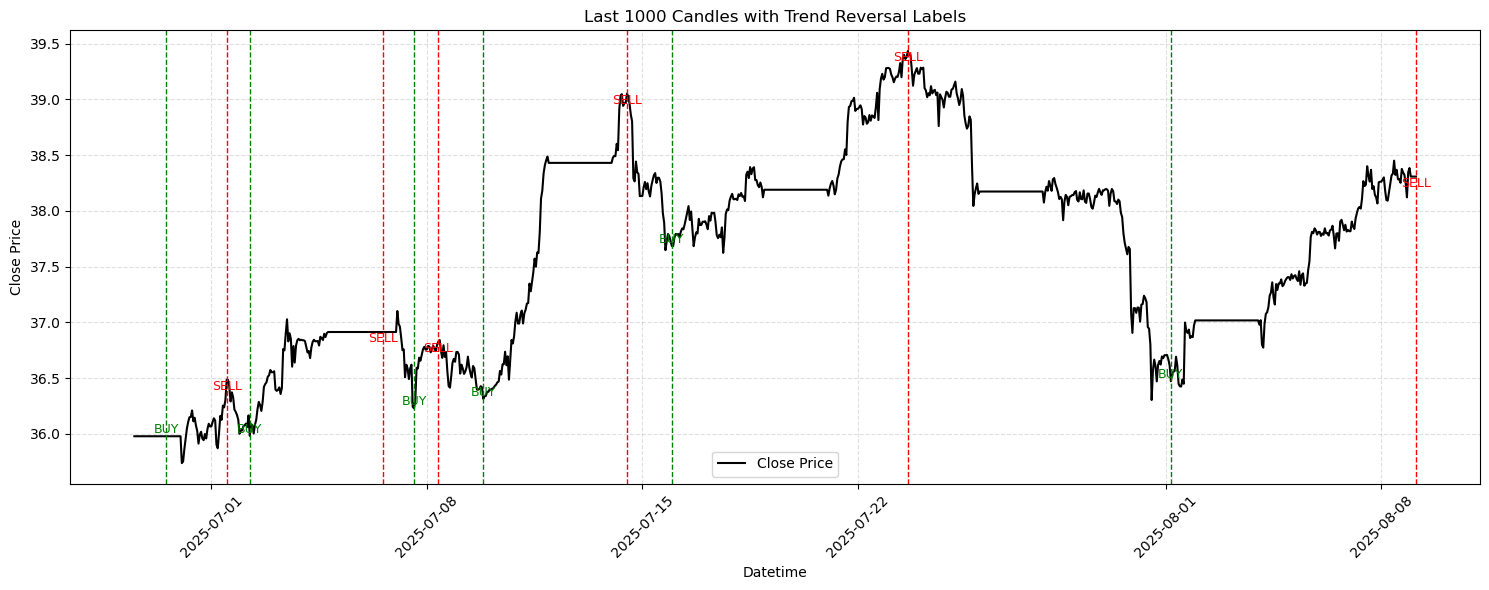

In [21]:
plot_labeled_candles(df_model)

In [24]:
# === Forex time-series classification: train + predict ===
# Assumptions:
# - df_model: pandas.DataFrame with continuous hourly rows (~130k) and columns:
#   ['DATETIME', 'DATE','TIME','OPEN','HIGH','LOW','CLOSE','TICKVOL','VOL','SPREAD','Label']
# - df: another DataFrame with same structure (used for prediction input)
# - Both have a DATETIME column parseable by pd.to_datetime
# - FEATURES to use: ['OPEN','HIGH','LOW','CLOSE','TICKVOL']
#
# Final output (last expression) is `predicted_df` with 10 rows:
#   DATETIME, forecast_class, prob_0, prob_1, prob_2

# --------------------------
# User hyperparameters
# --------------------------
WINDOW_SIZE = 60
FORECAST_HORIZON = 10
FEATURES = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']
N_CLASSES = 3  # 0=no signal,1=buy,2=sell

# Training hyperparams (tweak as needed)
VALIDATION_SPLIT = 0.1
MODEL_SAVE_PATH = "best_model_seq2seq.keras"

# --------------------------
# 0) Basic checks & prepare datetimes
# --------------------------
# Ensure DATETIME column is datetime dtype
for dfi in (df_model, df):
    if not np.issubdtype(dfi['DATETIME'].dtype, np.datetime64):
        dfi['DATETIME'] = pd.to_datetime(dfi['DATETIME'], dayfirst=False)

# Ensure feature columns exist
missing = [c for c in FEATURES if c not in df_model.columns]
if missing:
    raise ValueError(f"Missing feature columns in df_model: {missing}")

# --------------------------
# 1) Create sliding windows X and targets y from df_model
#    For each time t (index i) where i >= WINDOW_SIZE-1 and i+FORECAST_HORIZON < len(df_model),
#    X sample uses rows [i-WINDOW_SIZE+1 ... i] (WINDOW_SIZE rows)
#    Targets are Label at i+1 ... i+FORECAST_HORIZON (FORECAST_HORIZON labels)
# --------------------------
labels = df_model['Label'].astype(int).values
data_values = df_model[FEATURES].values  # shape (T, n_features)
T = len(df_model)

X_list = []
y_list = []

# We can form samples for i in [WINDOW_SIZE-1, T-FORECAST_HORIZON-1]
start_idx = WINDOW_SIZE - 1
end_idx = T - FORECAST_HORIZON - 1

for i in range(start_idx, end_idx + 1):
    x_window = data_values[i - WINDOW_SIZE + 1 : i + 1]  # shape (WINDOW_SIZE, n_features)
    y_horizon = labels[i + 1 : i + 1 + FORECAST_HORIZON]  # shape (FORECAST_HORIZON,)
    # sanity: ensure length
    if x_window.shape[0] != WINDOW_SIZE or y_horizon.shape[0] != FORECAST_HORIZON:
        continue
    X_list.append(x_window)
    y_list.append(y_horizon)

X = np.stack(X_list, axis=0)  # shape (N, WINDOW_SIZE, n_features)
y = np.stack(y_list, axis=0)  # shape (N, FORECAST_HORIZON)

print("Prepared dataset shapes:", X.shape, y.shape)

# --------------------------
# 2) Train / validation split
# --------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VALIDATION_SPLIT, shuffle=True, random_state=42)

# --------------------------
# 3) Scaling: fit scaler on training X (flatten time axis)
# --------------------------
# We'll fit a StandardScaler on the feature columns across all timesteps in the training set
scaler = StandardScaler()
# reshape to (N*WINDOW_SIZE, n_features)
X_train_2d = X_train.reshape(-1, X_train.shape[2])
scaler.fit(X_train_2d)

# transform both train and val
def scale_X(X_in):
    n_samples, win, n_feat = X_in.shape
    flat = X_in.reshape(-1, n_feat)
    flat_scaled = scaler.transform(flat)
    return flat_scaled.reshape(n_samples, win, n_feat)

X_train_scaled = scale_X(X_train)
X_val_scaled = scale_X(X_val)

# --------------------------
# 4) Convert targets to one-hot (for categorical crossentropy)
# --------------------------
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=N_CLASSES)  # shape (N, H, C)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=N_CLASSES)

# --------------------------
# 5) Handle class imbalance: compute class weights from flattened labels across training set
#    We'll compute weights per class and then create a sample_weight matrix of shape (N, H)
# --------------------------
y_train_flat = y_train.ravel()
class_counts = np.bincount(y_train_flat, minlength=N_CLASSES)
total = y_train_flat.shape[0]
# Avoid divide-by-zero
class_freq = np.maximum(class_counts, 1)
class_weights = total / (class_freq * N_CLASSES)  # inverse-frequency normalized
print("Class counts (train):", class_counts)
print("Computed class_weights:", class_weights)

# sample_weight matrix shape (N_samples, FORECAST_HORIZON)
# map each label to its class weight
sample_weight_train = np.vectorize(lambda lbl: class_weights[lbl])(y_train)
sample_weight_val = np.vectorize(lambda lbl: class_weights[lbl])(y_val)

# --------------------------
# 6) Build Seq2Seq-style model (encoder -> RepeatVector -> decoder LSTM with return_sequences)
#    Output: TimeDistributed Dense softmax with FORECAST_HORIZON time steps
# --------------------------
n_features = X_train_scaled.shape[2]
latent_units = 128
drop_rate = 0.2

inp = Input(shape=(WINDOW_SIZE, n_features), name="encoder_input")
x = LSTM(latent_units, return_sequences=False, name="encoder_lstm")(inp)
x = Dropout(drop_rate)(x)
x = BatchNormalization()(x)
# Repeat
x = RepeatVector(FORECAST_HORIZON)(x)
# Decoder
x = LSTM(128, return_sequences=True, name="decoder_lstm")(x)
x = Dropout(drop_rate)(x)
x = TimeDistributed(Dense(64, activation='relu'))(x)
out = TimeDistributed(Dense(N_CLASSES, activation='softmax'), name='out')(x)

model = Model(inp, out)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Prepared dataset shapes: (146287, 60, 5) (146287, 10)
Class counts (train): [1297459    9554    9567]
Computed class_weights: [ 0.33824576 45.93468704 45.87226926]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 64)         │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (TimeDistributed)           │ (None, 10, 3)          │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,155 (817.01 KB)

 Trainable params: 208,899 (816.01 KB)

 Non-trainable params: 256 (1.00 KB)

In [23]:
# --------------------------
# 7) Training callbacks
# --------------------------
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, verbose=1)

# Note: Keras accepts sample_weight shaped (samples, timesteps) for temporal weighting
# We'll provide sample_weight_train and sample_weight_val which are (N, FORECAST_HORIZON)
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat, sample_weight_val),
    epochs=200,
    batch_size=256,
    callbacks=[es, mc],
    sample_weight=sample_weight_train,
    verbose=1
)

# Save final scaler + model if desired
model.save("final_model.keras")  # recommended native Keras format

Epoch 1/200


2025-11-10 07:11:09.456291: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


514/515 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4182 - loss: 1.0947
Epoch 1: val_loss improved from None to 1.05629, saving model to best_model_seq2seq.keras
515/515 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.4183 - loss: 1.0724 - val_accuracy: 0.4520 - val_loss: 1.0563
Epoch 2/200
514/515 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3955 - loss: 1.0474
Epoch 2: val_loss improved from 1.05629 to 1.04821, saving model to best_model_seq2seq.keras
515/515 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step - accuracy: 0.3889 - loss: 1.0523 - val_accuracy: 0.3900 - val_loss: 1.0482
Epoch 3/200
514/515 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3789 - loss: 1.0622
Epoch 3: val_loss improved from 1.04821 to 1.04007, saving model to best_model_seq2seq.keras
515/515 ━━━━━━━━━━━━━━━━━━━━ 46s 89ms/step - accuracy: 0.3935 - loss: 1.0476 - val_accuracy: 0.3846 - val_loss: 1.0401
Epoch 4/200
514/515 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3696 - loss: 1.0460
Epoch 4: val_loss improved 

In [25]:
# --------------------------
# PREDICTION SECTION
# --------------------------
# Specification:
# - Use df (not df_model) to select 60 unseen candles ending at given_time
# - given_time = "2025.08.13 21:00:00" (user-provided format)
# - prepare the input, scale it, run model.predict, get probs and classes, build predicted_df
# --------------------------

given_time = "2025.08.13 21:00:00"
given_time_dt = pd.to_datetime(given_time)

# find the index in df where DATETIME == given_time_dt
if not np.issubdtype(df['DATETIME'].dtype, np.datetime64):
    df['DATETIME'] = pd.to_datetime(df['DATETIME'], infer_datetime_format=True)

matches = df.index[df['DATETIME'] == given_time_dt].tolist()
if len(matches) == 0:
    raise ValueError(f"given_time {given_time_dt} not found exactly in df['DATETIME']. If index is different, adjust or ensure times match.")
idx = matches[0]

# Ensure we have at least WINDOW_SIZE rows ending at idx (inclusive)
if idx - (WINDOW_SIZE - 1) < 0:
    raise ValueError(f"Not enough history before given_time index {idx} to build a window of size {WINDOW_SIZE}.")

input_df = df.iloc[idx - WINDOW_SIZE:idx].copy()
# sanity check
assert len(input_df) == WINDOW_SIZE
input_df

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
179409,2025-08-11 09:00:00,2025.08.11,09:00:00,38.187,38.218,38.047,38.050,2240.0,0.0,11.0
179410,2025-08-11 10:00:00,2025.08.11,10:00:00,38.049,38.065,37.608,37.696,3651.0,0.0,11.0
179411,2025-08-11 11:00:00,2025.08.11,11:00:00,37.700,37.958,37.700,37.928,2681.0,0.0,11.0
179412,2025-08-11 12:00:00,2025.08.11,12:00:00,37.928,37.981,37.844,37.874,2232.0,0.0,11.0
179413,2025-08-11 13:00:00,2025.08.11,13:00:00,37.873,37.961,37.773,37.791,1904.0,0.0,11.0
179414,2025-08-11 14:00:00,2025.08.11,14:00:00,37.790,37.829,37.676,37.726,2994.0,0.0,11.0
179415,2025-08-11 15:00:00,2025.08.11,15:00:00,37.722,37.801,37.553,37.801,3751.0,0.0,11.0
179416,2025-08-11 16:00:00,2025.08.11,16:00:00,37.800,37.890,37.732,37.878,3985.0,0.0,11.0
179417,2025-08-11 17:00:00,2025.08.11,17:00:00,37.877,37.899,37.708,37.764,3188.0,0.0,14.0
179418,2025-08-11 18:00:00,2025.08.11,18:00:00,37.764,37.775,37.696,37.737,1909.0,0.0,11.0


In [26]:


# select features and scale
X_input = input_df[FEATURES].values.reshape(1, WINDOW_SIZE, n_features)  # shape (1,60,n_feat)
# check feature count
if X_input.shape[2] != n_features:
    raise ValueError(f"Feature dimension mismatch: model expects {n_features} features, but X_input has {X_input.shape[2]}")

# scale with previously fitted scaler
X_input_flat = X_input.reshape(-1, n_features)
X_input_scaled_flat = scaler.transform(X_input_flat)
X_input_scaled = X_input_scaled_flat.reshape(1, WINDOW_SIZE, n_features)

# Run prediction
y_pred_prob = model.predict(X_input_scaled)  # shape (1, FORECAST_HORIZON, N_CLASSES)
y_pred_prob = np.squeeze(y_pred_prob, axis=0)  # (FORECAST_HORIZON, N_CLASSES)
y_pred_class = np.argmax(y_pred_prob, axis=1)  # (FORECAST_HORIZON,)

# Build forecast DATETIME list: next 10 hours immediately after given_time
forecast_datetimes = [given_time_dt + pd.Timedelta(hours=i) for i in range(FORECAST_HORIZON)]

predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': y_pred_class,
    'prob_0': y_pred_prob[:, 0],
    'prob_1': y_pred_prob[:, 1],
    'prob_2': y_pred_prob[:, 2],
})

# Final display/return: predicted_df is the last expression (as required)
predicted_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


,DATETIME,forecast_class,prob_0,prob_1,prob_2
0,2025-08-13 21:00:00,1,0.341067,0.341745,0.317188
1,2025-08-13 22:00:00,0,0.348015,0.347865,0.304120
2,2025-08-13 23:00:00,0,0.353929,0.352213,0.293858
3,2025-08-14 00:00:00,0,0.358710,0.355285,0.286005
4,2025-08-14 01:00:00,0,0.362486,0.357425,0.280089
5,2025-08-14 02:00:00,0,0.365366,0.358961,0.275673
6,2025-08-14 03:00:00,0,0.367424,0.360197,0.272379
7,2025-08-14 04:00:00,0,0.368765,0.361216,0.270019
8,2025-08-14 05:00:00,0,0.369381,0.362531,0.268088
9,2025-08-14 06:00:00,0,0.369727,0.363516,0.266758


# plot section

In [27]:
# --------------------------
# === Visualization Block ===
# --------------------------

historical_df = input_df.tail(4).copy()


In [28]:
# --- 2. Actual future 10 candles  ---
# Since input_df ends at index (start_idx - 1), actual_future_df starts right after that.
actual_future_start = idx
actual_future_end = idx + FORECAST_HORIZON
actual_future_df = df.iloc[actual_future_start - 1:actual_future_end].copy()


In [29]:
# --- 3. Create predicted_df (forecast for next 10 hours) ---
last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=FORECAST_HORIZON,
    freq='h'
)


# --- 4. Add text labels for clarity ---
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')


# --- 5. Plot title & output settings ---
plot_title = 'Actual vs Predicted Forex Trend Reversals'
output_plot_path = None  # e.g., 'forecast_plot.png'



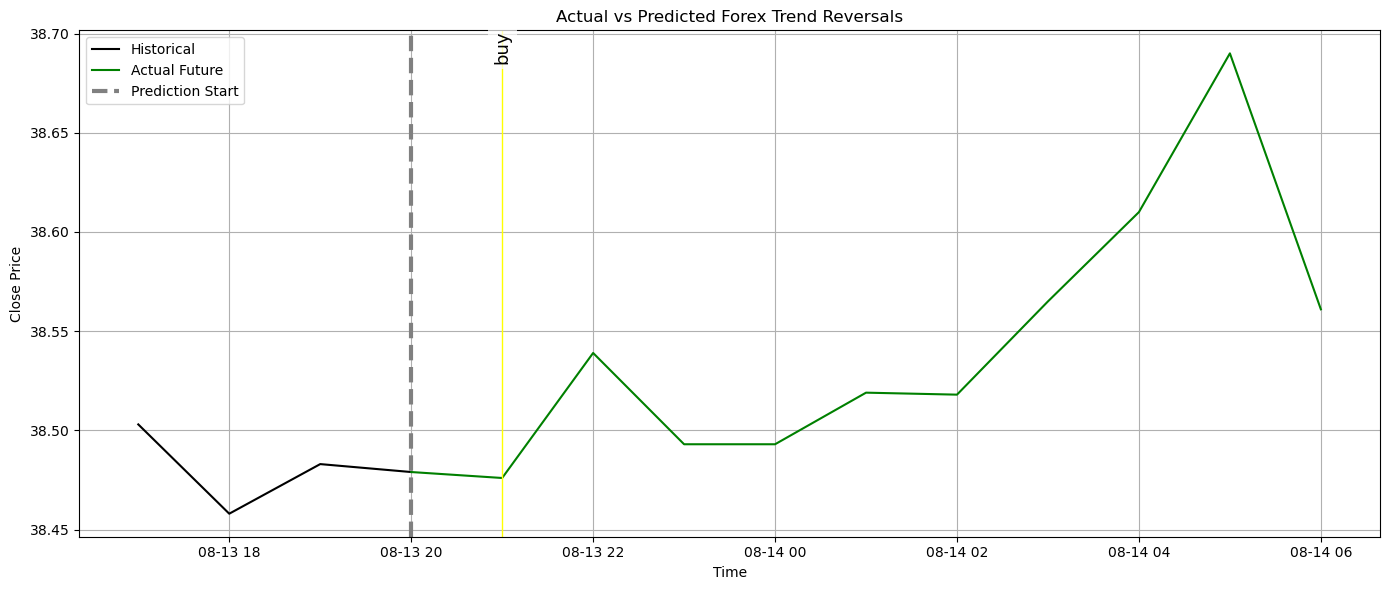

In [30]:
# --- 6. Import your plotting utility ---

import sys
sys.path.insert(1, '../utils')
import forex_plot_utils_2

# --- 7. Plot all series ---
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)


In [31]:
# 11- Save Model

from datetime import datetime
import os

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-5 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 4. Evaluate on validation set (since no X_test/y_test defined)
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss, final_val_acc = model.evaluate(X_val_scaled, y_val_cat, verbose=0)

# 5. Save model summary and performance metrics
summary_path = os.path.join(log_dir, 'model_log.txt')
with open(summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write('\n')
    f.write(f'Final Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Training Accuracy: {final_train_acc:.6f}\n')
    f.write(f'Final Validation Loss: {final_val_loss:.6f}\n')
    f.write(f'Final Validation Accuracy: {final_val_acc:.6f}\n')

In [ ]:
model_path = 'saved_models/model_20251110_073444.keras'
model = keras.models.load_model(
    model_path,
    safe_mode=False
)